In [6]:
# Set project directory
import os
import sys

def project_dir():
    notebook_path = %pwd
    repo_name = "nsl_kdd"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)

pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [106]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers as k_layers
from tensorflow.keras import optimizers as k_optimizers
from tensorflow.keras import callbacks as k_callbacks

from sklearn.decomposition import PCA

import time

from data_utils import load_train_test_data

# Preconditions

In [69]:
N_BOTTLENECK = [2, 4, 8, 16, 32]

# Load data

In [8]:
(X_train, X_test, Y_train, Y_test), attack_labels = load_train_test_data(pwd=pwd)

In [9]:
X = np.vstack([X_train, X_test])
Y = np.vstack([Y_train, Y_test])

X.shape, Y.shape

((148517, 122), (148517, 5))

In [10]:
attack_labels

array(['DoS', 'Probe', 'R2L', 'U2R', 'normal'], dtype='<U6')

# Utils

In [67]:
def fit_model(create_model, X_train, bottleneck=10, batch_size=4096, n_epochs=100, lr_start=0.001, lr_patience=None):
    model = create_model(bottleneck, lr_start)
    
    callbacks = []
    if lr_patience is not None:
        callbacks.append(k_callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=lr_patience))
        
    history = model.fit(X_train, X_train, batch_size=batch_size, epochs=n_epochs, callbacks=callbacks).history
    
    return history, model

def plot_history(history, title, ymax=None):
    plt.figure(figsize=(10, 7))
    
    X = np.arange(1, len(history['loss']) + 1)
    
    plt.plot(X, history['loss'], label='train')
    
    if ymax is not None:
        plt.ylim(0, ymax)

    plt.title(f"loss ({history[f'loss'][-1]:0.4f})")
    plt.grid()
    plt.legend()
        
    plt.suptitle(title)
    plt.show()

In [85]:
def run_and_measure(fun, *args, **kwargs):
    start = time.time()
    retval = fun(*args, **kwargs)
    end = time.time()
    return retval, end - start

def test_autoencoder(create_model, X, n_bottleneck_list, name, batch_size=8192, n_epochs=50, train=True, lr_start=0.001, lr_patience=None):
    histories = {}
    models = {}

    for n_bottleneck in n_bottleneck_list:
        print(f"Starting {n_bottleneck}... ", end="")

        autoencoder_model = create_model(n_bottleneck, lr=lr_start)
        models[n_bottleneck] = autoencoder_model

        if train:
            callbacks = []
            if lr_patience is not None:
                callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=lr_patience, min_delta=0.00005))

            history, t = run_and_measure(autoencoder_model.fit, X, X, batch_size=batch_size, verbose=0, epochs=n_epochs, callbacks=callbacks)
            print(f"{t:0.2f} s")
            history = history.history
        #     autoencoder_model.save_weights(
        #         f"model_checkpoints/{name}/{n_bottleneck}/weights"
        #     )
        #     pd.DataFrame(history).to_csv(
        #         f"model_checkpoints/{name}/{n_bottleneck}/log.csv"
        #     )
        # else:
        #     history = pd.read_csv(f"model_checkpoints/{name}/{n_bottleneck}/log.csv")
        #     autoencoder_model.load_weights(
        #         f"model_checkpoints/{name}/{n_bottleneck}/weights"
        #     )
        #     print()

        histories[n_bottleneck] = history

    return histories, models

def plot_histories(histories, title, ymax=1, print_mse=True):
    plt.figure(figsize=(12, 8))

    for n_bottleneck, history in histories.items():
        plt.plot(np.arange(1, len(history["loss"]) + 1), history["loss"], label=f"{n_bottleneck}")

    plt.ylim(0, ymax)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

    for n_bottleneck, history in histories.items():
        print(f"n_bottleneck={n_bottleneck:2}: mse={min(history['loss']):0.6f}")

# PCA

In [107]:
pca = PCA()
X_pca = pca.fit_transform(X)

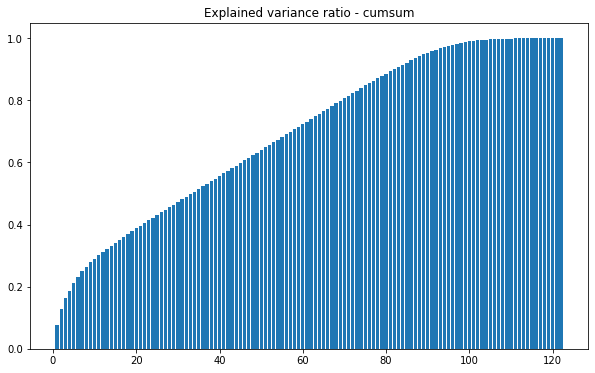

In [108]:
plt.figure(figsize=(10, 6))
plt.bar(
    np.arange(1, pca.explained_variance_ratio_.shape[0] + 1),
    pca.explained_variance_ratio_.cumsum(),
)
plt.title("Explained variance ratio - cumsum")
plt.show()

In [109]:
from sklearn.metrics import mean_squared_error

for i in range(1, 100, 4):
    X_tmp = X_pca[:, :i] @ pca.components_[:i] + pca.mean_
    mse = mean_squared_error(X, X_tmp)
    print(f"First {i:2} components: mse={mse:0.6f}")

First  1 components: mse=0.907731
First  2 components: mse=0.858080
First  3 components: mse=0.824530
First  4 components: mse=0.800534
First  5 components: mse=0.777035
First  6 components: mse=0.755598
First  7 components: mse=0.738188
First  8 components: mse=0.723905
First  9 components: mse=0.710755
First 10 components: mse=0.698715
First 11 components: mse=0.687812
First 12 components: mse=0.677450
First 13 components: mse=0.667260
First 14 components: mse=0.657384
First 15 components: mse=0.647761
First 16 components: mse=0.638350
First 17 components: mse=0.629043
First 18 components: mse=0.619827
First 19 components: mse=0.610923
First 20 components: mse=0.602368
First 21 components: mse=0.593847
First 22 components: mse=0.585397
First 23 components: mse=0.577041
First 24 components: mse=0.568716
First 25 components: mse=0.560417
First 26 components: mse=0.552136
First 27 components: mse=0.543871
First 28 components: mse=0.535616
First 29 components: mse=0.527371
First 30 compo

# Model v1

In [86]:
def create_model_v1(bottleneck=10, lr=0.001):
    model = tf.keras.Sequential([
        k_layers.Input(122),
        
        k_layers.Dense(bottleneck),
        
        k_layers.Dense(122)
    ])
    
    model.compile(
        k_optimizers.Adam(learning_rate=lr), loss='mse'
    )
    
    return model

# create_model_v1().summary()

In [87]:
histories_v1, models_v1 = test_autoencoder(create_model_v1, X, N_BOTTLENECK, 'model_v1', n_epochs=50, lr_start=0.001, lr_patience=10)

Starting 2... 4.07 s
Starting 4... 4.25 s
Starting 8... 4.39 s
Starting 16... 4.44 s
Starting 32... 4.50 s


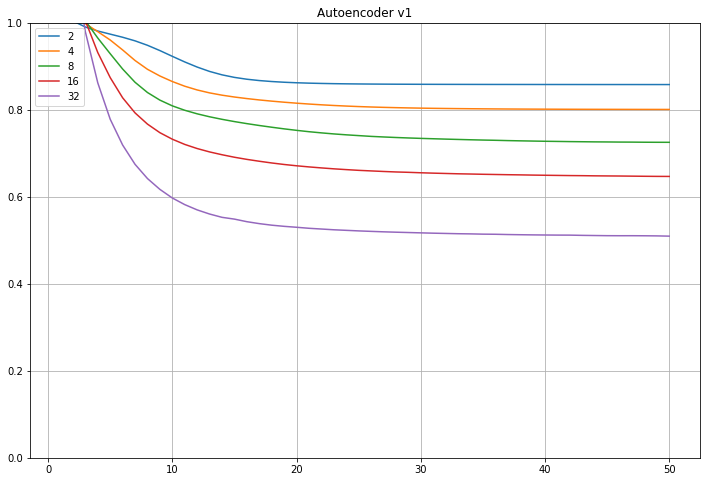

n_bottleneck= 2: mse=0.858267
n_bottleneck= 4: mse=0.801030
n_bottleneck= 8: mse=0.725454
n_bottleneck=16: mse=0.646994
n_bottleneck=32: mse=0.509696


In [88]:
plot_histories(histories_v1, "Autoencoder v1")

# Model v2

In [89]:
def create_model_v2(bottleneck=10, lr=0.001):
    model = tf.keras.Sequential([
        k_layers.Input(122),
        
        k_layers.Dense(61, activation='relu'),  
        k_layers.Dense(bottleneck), 
        
        k_layers.Dense(61, activation='relu'),
        k_layers.Dense(122)
    ])
    
    model.compile(
        k_optimizers.Adam(learning_rate=lr), loss='mse'
    )
    
    return model

# create_model_v2().summary()

In [93]:
histories_v2, models_v2 = test_autoencoder(create_model_v2, X, N_BOTTLENECK, 'model_v2', n_epochs=100, lr_start=0.001, lr_patience=10)

Starting 2... 9.93 s
Starting 4... 9.66 s
Starting 8... 9.29 s
Starting 16... 9.51 s
Starting 32... 9.83 s


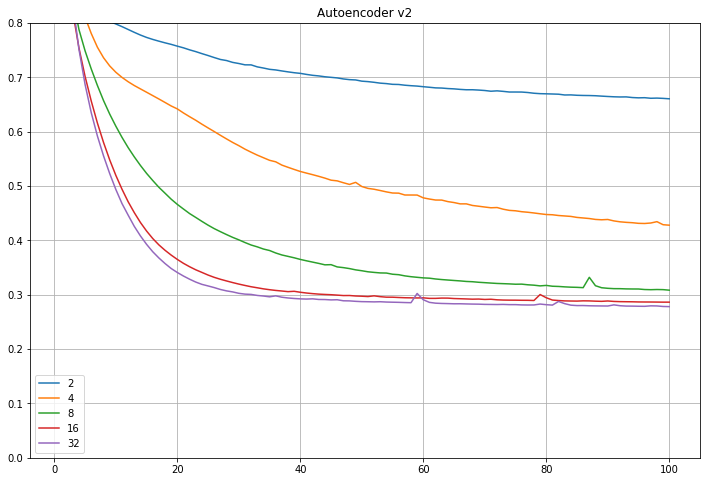

n_bottleneck= 2: mse=0.660421
n_bottleneck= 4: mse=0.427928
n_bottleneck= 8: mse=0.308368
n_bottleneck=16: mse=0.286325
n_bottleneck=32: mse=0.278103


In [94]:
plot_histories(histories_v2, "Autoencoder v2", ymax=0.8)

# Model v3

In [100]:
def create_model_v3(bottelneck=10, lr=0.001):
    model = tf.keras.Sequential([
        k_layers.Input(122),
        
        k_layers.Dense(110, activation='relu'),
        k_layers.Dense(100, activation='relu'),
        k_layers.Dense(90, activation='relu'),
        k_layers.Dense(80, activation='relu'),
        k_layers.Dense(70, activation='relu'),
        k_layers.Dense(60, activation='relu'),
        k_layers.Dense(50, activation='relu'),
        k_layers.Dense(40, activation='relu'),
        k_layers.Dense(bottelneck),

        k_layers.Dense(40, activation='relu'),
        k_layers.Dense(50, activation='relu'),
        k_layers.Dense(60, activation='relu'),
        k_layers.Dense(70, activation='relu'),
        k_layers.Dense(80, activation='relu'),
        k_layers.Dense(90, activation='relu'),
        k_layers.Dense(100, activation='relu'),
        k_layers.Dense(110, activation='relu'),
        k_layers.Dense(122)
    ])
    
    model.compile(
        k_optimizers.Adam(learning_rate=lr), loss='mse'
    )
    
    return model
    
# create_model_v3().summary()

In [103]:
histories_v3, models_v3 = test_autoencoder(create_model_v3, X, N_BOTTLENECK, 'model_v3', n_epochs=100, lr_start=0.001, lr_patience=10)

Starting 2... 22.61 s
Starting 4... 22.45 s
Starting 8... 22.78 s
Starting 16... 22.96 s
Starting 32... 22.25 s


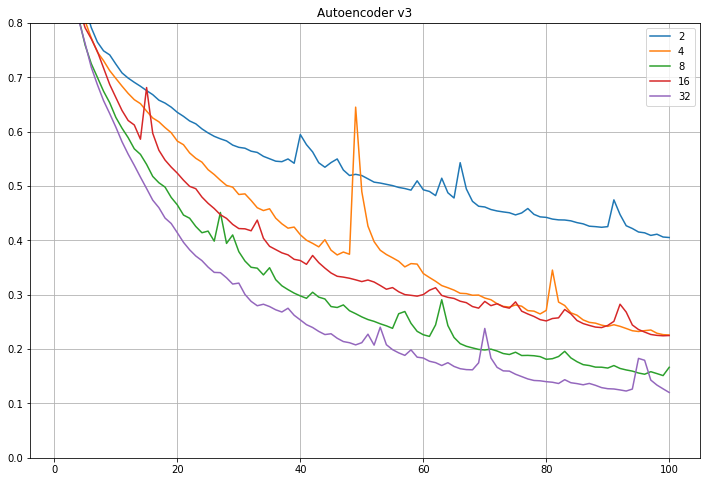

n_bottleneck= 2: mse=0.405221
n_bottleneck= 4: mse=0.225880
n_bottleneck= 8: mse=0.151231
n_bottleneck=16: mse=0.224448
n_bottleneck=32: mse=0.120129


In [105]:
plot_histories(histories_v3, "Autoencoder v3", ymax=0.8)